# Import Library

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys
sys.path.insert(0,'/content/drive/Shareddrives/elsa_infinity/Master/Brain_Computer_Interface')

In [3]:
!pip3 install mne==1.3.1
!pip3 install mne_icalabel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import os
import mne
import openpyxl
import numpy as np
import matplotlib.pyplot as plt

from asrpy.asrpy import ASR
from mne_icalabel import label_components

In [ ]:
dir_path = "/content/drive/Shareddrives/elsa_infinity/Master/Brain_Computer_Interface/"
raw = mne.io.read_raw_fif(dir_path + "P01-raw.fif", preload=True)
raw.set_eeg_reference()
raw.set_montage('biosemi64')
raw.interpolate_bads()


In [35]:
print(raw.n_times)
print(raw.n_times / raw.info['sfreq'] / 60)

2478166
80.66946614583334


In [36]:
raw.crop(tmin=10, tmax=40)

15361

In [37]:
# bandpass-filter
eeg_picks = mne.pick_types(raw.info, meg=False, eeg=True, eog=False, stim=False, exclude=[])
fmin = 1
fmax = 30
raw.filter(fmin, fmax, picks=eeg_picks, filter_length='10s',
           l_trans_bandwidth=0.1, h_trans_bandwidth=0.5, method='iir',
           verbose=True)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 30.00 Hz: -6.02, -6.02 dB



<Raw | P01-raw.fif, 69 x 15361 (30.0 s), ~8.2 MB, data loaded>

In [ ]:
trial_events = mne.find_events(raw, stim_channel='STI 014', shortest_event=0)
beat_events = generate_beat_events(raw, trial_events)

<Epochs |  52 events (all good), -0.199219 - 0.800781 sec, baseline -0.199219 – 0 sec, ~14.1 MB, data loaded,
 '112201': 2
 '112202': 2
 '112203': 2
 '112211': 8
 '112212': 8
 '112213': 8
 '112311': 8
 '112312': 7
 '112313': 7>


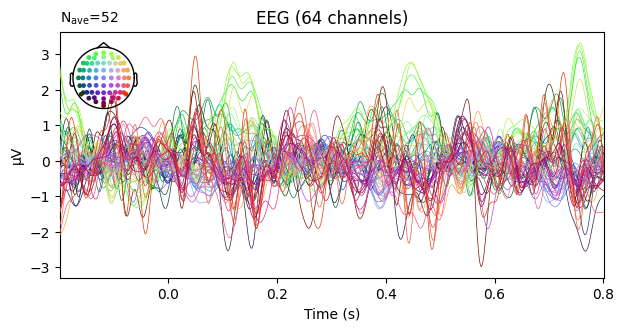

In [39]:
picks = mne.pick_types(raw.info, meg=False, eeg=True, eog=True, stim=True, exclude=[])
event_id = None # any
tmin = -0.2  # start of each epoch (200ms before the trigger)
tmax = 0.8  # end of each epoch (600ms after the trigger) - longest beat is 0.57s long
detrend = 0 # remove dc
beat_epochs = mne.Epochs(raw, beat_events, event_id,
                              tmin, tmax, preload=True,
                              proj=False, picks=picks, verbose=False)
print(beat_epochs)
a = beat_epochs.average().plot()

In [40]:
asr = ASR(sfreq=raw.info["sfreq"], cutoff=20)
asr.fit(raw)
print("asr fitted")
asr_raw = asr.transform(raw)
print("asr transformed")

asr fitted
asr transformed


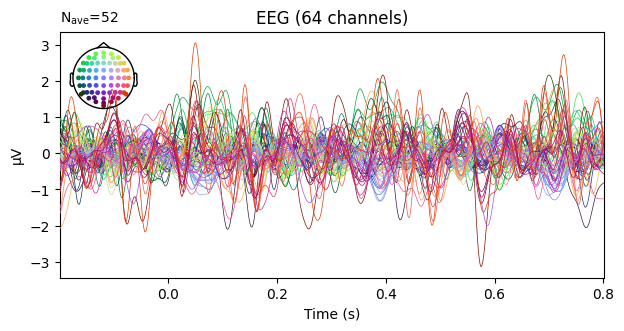

In [41]:
picks = mne.pick_types(asr_raw.info, meg=False, eeg=True, eog=True, stim=True, exclude=[])
event_id = None # any
tmin = -0.2  # start of each epoch (200ms before the trigger)
tmax = 0.8  # end of each epoch (600ms after the trigger) - longest beat is 0.57s long
detrend = 0 # remove dc
clean_beat_epochs = mne.Epochs(asr_raw, beat_events, event_id,
                              tmin, tmax, preload=True,
                              proj=False, picks=picks, verbose=False)
p = clean_beat_epochs.average().plot()

In [50]:
def compute_ica(beat_epochs, random_seed=42):
    random_state = np.random.RandomState(random_seed)
    ica = mne.preprocessing.ICA(n_components=0.99, method='infomax', fit_params=dict(extended=True), random_state=random_state)
    ica.fit(beat_epochs)
    return ica
 ## aux functions to be moved to lib
def plot_ica_components(ica, picks=None, topomap_size=3.5):

    if picks is None:
        n_components = ica.mixing_matrix_.shape[1]
        picks = list(range(n_components))
    if len(picks) == 0:
        print('nothing selected for plotting')
        return
    ica.plot_components(picks=picks, ch_type='eeg', title='', colorbar=True, show=False)
    axes = plt.gcf()
    axes.set_size_inches(min(len(picks), 5) * topomap_size, max(len(picks)/5.0, 1) * topomap_size)
    plt.show()
ica = compute_ica(clean_beat_epochs)
# plot_ica_components(ica)

Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by explained variance: 50 components
Computing Extended Infomax ICA


<ipython-input-50-d3c9015d6dd9>:4: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(beat_epochs)


Fitting ICA took 27.1s.


In [51]:


ans = label_components(asr_raw, ica, method='iclabel')
d = {}
for label in ans["labels"]:
    if label not in d:
        d[label] = 1
    else:
        d[label] += 1
print(d)
for i in range(0, 6):
    for j in range(0, 50):
        if i*10+j >= 48:
            continue
        print("ICA {}{} - {}, ".format(i, j, ans["labels"][i*10+j]), end='')
        if j == 4 or j == 9:
            print()

<ipython-input-51-79c4ac45b967>:3: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ans = label_components(asr_raw, ica, method='iclabel')


{'brain': 9, 'other': 39, 'muscle artifact': 1, 'channel noise': 1}
ICA 00 - brain, ICA 01 - other, ICA 02 - other, ICA 03 - other, ICA 04 - other, 
ICA 05 - brain, ICA 06 - brain, ICA 07 - brain, ICA 08 - other, ICA 09 - other, 
ICA 010 - brain, ICA 011 - other, ICA 012 - brain, ICA 013 - other, ICA 014 - other, ICA 015 - muscle artifact, ICA 016 - other, ICA 017 - other, ICA 018 - other, ICA 019 - channel noise, ICA 020 - other, ICA 021 - other, ICA 022 - other, ICA 023 - other, ICA 024 - other, ICA 025 - other, ICA 026 - other, ICA 027 - other, ICA 028 - other, ICA 029 - other, ICA 030 - other, ICA 031 - brain, ICA 032 - other, ICA 033 - other, ICA 034 - other, ICA 035 - other, ICA 036 - other, ICA 037 - other, ICA 038 - other, ICA 039 - other, ICA 040 - brain, ICA 041 - other, ICA 042 - other, ICA 043 - other, ICA 044 - other, ICA 045 - other, ICA 046 - other, ICA 047 - other, ICA 10 - brain, ICA 11 - other, ICA 12 - brain, ICA 13 - other, ICA 14 - other, 
ICA 15 - muscle artifact,

In [46]:
ica = compute_ica(beat_epochs)
ans = label_components(raw, ica, method='iclabel')

Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by explained variance: 46 components
Computing Extended Infomax ICA


<ipython-input-42-878119e767b3>:4: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(beat_epochs)


Fitting ICA took 17.8s.


<ipython-input-46-72514b9b4da7>:2: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ans = label_components(raw, ica, method='iclabel')


In [48]:
d = {}
for label in ans["labels"]:
    if label not in d:
        d[label] = 1
    else:
        d[label] += 1
print(d)
for i in range(0, 5):
    for j in range(0, 10):
        if i*10+j >= 46:
            continue
        print("ICA {}{} - {}, ".format(i, j, ans["labels"][i*10+j]), end='')
        if j == 4 or j == 9:
            print()

{'eye blink': 1, 'other': 36, 'brain': 7, 'channel noise': 2}
ICA 00 - eye blink, ICA 01 - other, ICA 02 - brain, ICA 03 - brain, ICA 04 - other, 
ICA 05 - brain, ICA 06 - brain, ICA 07 - other, ICA 08 - other, ICA 09 - brain, 
ICA 10 - other, ICA 11 - other, ICA 12 - channel noise, ICA 13 - other, ICA 14 - other, 
ICA 15 - other, ICA 16 - other, ICA 17 - other, ICA 18 - other, ICA 19 - other, 
ICA 20 - other, ICA 21 - other, ICA 22 - other, ICA 23 - other, ICA 24 - other, 
ICA 25 - channel noise, ICA 26 - brain, ICA 27 - other, ICA 28 - other, ICA 29 - other, 
ICA 30 - other, ICA 31 - other, ICA 32 - other, ICA 33 - other, ICA 34 - other, 
ICA 35 - other, ICA 36 - other, ICA 37 - other, ICA 38 - other, ICA 39 - brain, 
ICA 40 - other, ICA 41 - other, ICA 42 - other, ICA 43 - other, ICA 44 - other, 
ICA 45 - other, 

In [ ]:
beat_events = generate_beat_events(raw, trial_events)
picks = mne.pick_types(raw.info, meg=False, eeg=True, eog=True, stim=True, exclude=[])
event_id = None # any
tmin = -0.2  # start of each epoch (200ms before the trigger)
tmax = 0.8  # end of each epoch (600ms after the trigger) - longest beat is 0.57s long
detrend = 0 # remove dc
beat_epochs = mne.Epochs(raw, beat_events, event_id,
                              tmin, tmax, preload=True,
                              proj=False, picks=picks, verbose=False)

### Helper Function
- `compute_ica(beat_epochs, random_seed=42)`
- `plot_ica_components(ica, picks=None, topomap_size=3.5)`
- `merge_trial_and_audio_onsets(raw, use_audio_onsets=True, inplace=True stim_channel='STI 014', verbose=None)`
- `generate_beat_events(raw, trial_events)`
- `find_eog_artifact_sources(ica, raw, plot=True, verbose=None)`
- `auto_detect_artifact_components(ica, beat_epochs, eog_exclude_inds)`
- `read_data(filepath, filter=False)`
- `generate_data_and_label(raw, events, condition, epoch=False)`

In [5]:
def compute_ica(beat_epochs, random_seed=42):
    random_state = np.random.RandomState(random_seed)
    ica = mne.preprocessing.ICA(n_components=0.99, method='infomax', fit_params=dict(extended=True), random_state=random_state)
    ica.fit(beat_epochs)
    return ica
 ## aux functions to be moved to lib
def plot_ica_components(ica, picks=None, topomap_size=3.5):
    if picks is None:
        n_components = ica.mixing_matrix_.shape[1]
        picks = list(range(n_components))
    if len(picks) == 0:
        print('nothing selected for plotting')
        return
    ica.plot_components(picks=picks, ch_type='eeg', title='', colorbar=True, show=False)
    axes = plt.gcf()
    axes.set_size_inches(min(len(picks), 5) * topomap_size, max(len(picks)/5.0, 1) * topomap_size)
    plt.show()

In [6]:
def merge_trial_and_audio_onsets(raw, use_audio_onsets=True, inplace=True, stim_channel='STI 014', verbose=None):
    events = mne.find_events(raw, stim_channel='STI 014', shortest_event=0)

    merged = list()
    last_trial_event = None
    for i, event in enumerate(events):
        etype = event[2]
        if etype < 1000 or etype == 1111: # trial or noise onset
            if use_audio_onsets and events[i+1][2] == 1000: # followed by audio onset
                onset = events[i+1][0]
                merged.append([onset, 0, etype])
                if verbose:
                    print('merged {} + {} = {}'.format(event, events[i+1], merged[-1]))
            else:
                # either we are not interested in audio onsets or there is none
                merged.append(event)
                if verbose:
                    print('kept {}'.format(merged[-1]))
        # audio onsets (etype == 1000) are not copied
        if etype > 1111: # other events (keystrokes)
            merged.append(event)
            if verbose:
                print('kept other {}'.format(merged[-1]))

    merged = np.asarray(merged, dtype=int)

    if inplace:
        stim_id = raw.ch_names.index(stim_channel)
        raw._data[stim_id,:].fill(0)     # delete data in stim channel
        raw.add_events(merged)

    return merged

In [7]:
import os
import mne
import openpyxl
import numpy as np
import matplotlib.pyplot as plt

DEFAULT_VERSION = 1
CONDITIONS = ['cued', 'non-cued', 'free']
STIMULUS_IDS = [1, 2, 3, 4, 11, 12, 13, 14, 21, 22, 23, 24]

def load_stimuli_metadata(data_root=None, version=None, verbose=None):

    if version is None:
        version = DEFAULT_VERSION

    # if data_root is None:
        # data_root = os.path.join(deepthought.DATA_PATH, 'OpenMIIR')

    xlsx_filepath = os.path.join(data_root, 'meta', 'Stimuli_Meta.v{}.xlsx'.format(version))
    book = openpyxl.load_workbook(xlsx_filepath, data_only=True)
    sheet = book.worksheets[0]

    if verbose:
        print('Loading stimulus metadata from {}'.format(xlsx_filepath))

    meta = dict()
    for i in range(2, 14):
        stimulus_id = int(sheet.cell(i, 1).value)
        meta[stimulus_id] = {
            'id' : stimulus_id,
            'label' : sheet.cell(i,2).value,
            'audio_file' : sheet.cell(i,3).value,
            'cue_file' : sheet.cell(i,3).value.replace('.wav', '_cue.wav'),
            'length_with_cue' : sheet.cell(i,4).value,
            'length_of_cue' : sheet.cell(i,5).value,
            'length_without_cue' : sheet.cell(i,6).value,
            'length_of_cue_only' : sheet.cell(i,7).value,
            'cue_bpm' : int(sheet.cell(i,8).value),
            'beats_per_bar' : int(sheet.cell(i,9).value),
            'num_bars' : int(sheet.cell(i,15).value),
            'cue_bars' : int(sheet.cell(i,16).value),
            'bpm' : int(sheet.cell(i,17).value),
            'approx_bar_length' : sheet.cell(i,12).value,
        }

        if version == 2:
            meta[stimulus_id]['bpm'] = meta[stimulus_id]['cue_bpm'] # use cue bpm

    return meta

def load_beat_times(stimulus_id, cue=False, data_root=None, verbose=None, version=None):

    if version is None:
        version = DEFAULT_VERSION

    if data_root is None:
        print("error")
        return

    if cue:
        beats_filepath = os.path.join(data_root, 'meta',
                                      'beats.v{}'.format(version),
                                      '{}_cue_beats.txt'.format(stimulus_id))
    else:
        beats_filepath = os.path.join(data_root, 'meta',
                                      'beats.v{}'.format(version),
                                      '{}_beats.txt'.format(stimulus_id))

    with open(beats_filepath, 'r') as f:
        lines = f.readlines()

    beats = []
    for line in lines:
        if not line.strip().startswith('#'):
            beats.append(float(line.strip()))
    beats = np.asarray(beats)

    if verbose:
        print('Read {} beat times from {}'.format(len(beats), beats_filepath))

    return beats

def load_stimuli_metadata_map(key=None, data_root=None, verbose=None, version=None):

    if version is None:
        version = DEFAULT_VERSION

    # handle special case for beats
    if key == 'cue_beats':
        key = 'beats'
        cue = True
    else:
        cue = False

    if key == 'beats':
        map = dict()
        for stimulus_id in STIMULUS_IDS:
            map[stimulus_id] = load_beat_times(stimulus_id,
                                               cue=cue,
                                               data_root=data_root,
                                               verbose=None,
                                               version=version)
        return map

    meta = load_stimuli_metadata(data_root, version=version)

    if key is None:
        return meta  # return everything

    map = dict()
    for stimulus_id in STIMULUS_IDS:
        map[stimulus_id] = meta[stimulus_id][key]

    return map

def beat_event_id_generator(stimulus_id, condition, cue, beat_count):
    if cue:
        cue = 0
    else:
        cue = 10
    return 100000 + stimulus_id * 1000 + condition * 100 + cue + beat_count


        
def decode_event_id(event_id):
    if event_id < 1000:
        stimulus_id = int(event_id / 10)
        condition = int(event_id % 10)
        return stimulus_id, condition
    else:
        return event_id
    
def generate_beat_events(raw, trial_events):
    meta = load_stimuli_metadata(data_root=dir_path+"openmiir")
    beats = load_stimuli_metadata_map(data_root=dir_path+"openmiir", key='beats')
    cue_beats = load_stimuli_metadata_map(data_root=dir_path+"openmiir", key='cue_beats')

    ## determine the number of cue beats
    num_cue_beats = dict()
    for stimulus_id in STIMULUS_IDS:
        num_cue_beats[stimulus_id] = \
            meta[stimulus_id]['beats_per_bar'] * meta[stimulus_id]['cue_bars']
    # print(num_cue_beats)
    
    beat_events = []
    
    ## helper function to add a single beat event
    def add_beat_event(etime, stimulus_id, condition, beat_count, cue=False):
        etype = beat_event_id_generator(stimulus_id, condition, cue, beat_count)
        beat_events.append([etime, 0, etype])
        # print(beat_events[-1])

    ## helper function to add a batch of beat events
    def add_beat_events(etimes, stimulus_id, condition, cue=False):
        beats_per_bar = meta[stimulus_id]['beats_per_bar']
        for i, etime in enumerate(etimes):
            beat_count = (i % beats_per_bar) + 1
            add_beat_event(etime, stimulus_id, condition, beat_count, cue)

    use_audio_onset = True
    include_cue_beats = True
    sr = raw.info['sfreq']
    for i, event in enumerate(trial_events):
        etype = event[2]
        etime = event[0]

        # print('{:4d} at {:8d}'.format(etype, etime))

        if etype >= 1000: # stimulus_id + condition
            continue

        stimulus_id, condition = decode_event_id(etype)

        trial_start = etime # default: use trial onset
        if use_audio_onset and condition < 3:
            # Note: conditions 3 and 4 have no audio cues
            next_event = trial_events[i+1]
            if next_event[2] == 1000: # only use if audio onset
                trial_start = next_event[0]

        # print('Trial start at {}'.format(trial_start))
        # print(stimulus_id, condition)
        if condition < 3: # cued
            offset = sr * meta[stimulus_id]['length_of_cue']

            if include_cue_beats:
                cue_beat_times = trial_start + np.floor(sr * cue_beats[stimulus_id])
                cue_beat_times = cue_beat_times[:num_cue_beats[stimulus_id]]  # truncate at num_cue_beats
                cue_beat_times = np.asarray(cue_beat_times, dtype=int)
                # print(cue_beat_times)
                add_beat_events(cue_beat_times, stimulus_id, condition, cue=True)
        else:
            offset = 0 # no cue

        beat_times = trial_start + offset + np.floor(sr * beats[stimulus_id])
        beat_times = np.asarray(beat_times, dtype=int)
        # print(beat_times[:5], '...')
        add_beat_events(beat_times, stimulus_id, condition)

    beat_events = np.asarray(beat_events, dtype=int)
    return beat_events

## aux function to score EEG channels by EOG correlation
def find_eog_artifact_sources(ica, raw, plot=True, verbose=None):

    eog_picks = mne.pick_types(raw.info, meg=False, eeg=False, eog=True, stim=False)
    eog_inds_set = set()
    multi_scores = list()
    for ch in eog_picks:
        ch_name = raw.ch_names[ch]
        eog_inds, scores = ica.find_bads_eog(raw, str(ch_name), verbose=verbose)
    #     print eog_inds, scores
        if plot:
            ica.plot_scores(scores, exclude=eog_inds, title='EOG artifact sources (red) for channel {}'.format(ch_name))

        multi_scores.append(scores)
        eog_inds_set.update(eog_inds)
    multi_scores = np.vstack(multi_scores)
    # print multi_scores.shape

    # IMPORTANT: due to a + operation meant to concatenate lists, ica.excluded and eog_inds must be lists, not ndarrays
    # see _pick_sources() in ica.py, line 1160
    eog_inds = list(eog_inds_set)
    scores = np.max(np.abs(multi_scores), axis=0).squeeze()

    print('suggested EOG artifact channels: ', eog_inds)
    print('EOG artifact component scores: ', scores[eog_inds])
    return eog_inds, scores
    
    # self.merge_artifact_components() # update 
    
## aux function for readable one-liner code in notebook
def merge_artifact_components(eog_exclude_inds=None, audo_exclude_inds=None):

    sets = list()
    if eog_exclude_inds:
        sets.append(eog_exclude_inds)
    if auto_exclude_inds:
        sets.append(auto_exclude_inds)

    if len(sets) == 1:
        merged = sets[0]
    else:
        print('merging', sets)
        merged = set()
        for s in sets:
            for e in s:
                merged.add(e)
        merged = sorted(list(merged))
    return merged

    # self.suggested_artifact_components = merged
    
def auto_detect_artifact_components(ica, beat_epochs, eog_exclude_inds):

    data = beat_epochs

    """
    data: raw, epochs or evoked
    """

    exclude_old = ica.exclude  # store old setting
    ica.exclude = []
    ica.detect_artifacts(data)
    auto_exclude = ica.exclude
    ica.exclude = exclude_old  # restore old setting

    suggested_artifact_components = merge_artifact_components(eog_exclude_inds=eog_exclude_inds, auto_exclude_indx=auto_exclude) # update combination
    return suggested_artifact_components

In [8]:
dir_path = "/content/drive/Shareddrives/elsa_infinity/Master/Brain_Computer_Interface/"

def read_data(filepath, filter=False):
  raw = mne.io.read_raw_fif(dir_path + filepath, preload=True)
  subject = filepath.split('-')[0]
  if subject in ['P09', 'P11', 'P12', 'P13', 'P14']:
    raw.set_eeg_reference(['EXG5', 'EXG6'])
    raw.drop_channels(['EXG5', 'EXG6'])
  else:
    raw.set_eeg_reference()
  raw.set_montage('biosemi64', on_missing='ignore')
  raw.interpolate_bads()

  if filter:
    # bandpass-filter
    eeg_picks = mne.pick_types(raw.info, meg=False, eeg=True, eog=False, stim=False, exclude=[])
    fmin = 1
    fmax = 30
    raw.filter(fmin, fmax, picks=eeg_picks, filter_length='10s',
              l_trans_bandwidth=0.1, h_trans_bandwidth=0.5, method='iir',
              verbose=True)

  # merge
  merge_trial_and_audio_onsets(raw, use_audio_onsets=True, inplace=True)

  # recompute trial_events and times
  trial_events = mne.find_events(raw, stim_channel='STI 014', shortest_event=0)
  trial_event_times = raw.times[trial_events[:,0]]
  return raw, trial_events

def generate_data_and_label(raw, trial_events, condition, epoch=False):
  """
  Parameter
    - raw
    - events (trial events)
    - condition
      1. Perception vs. Imagination
      2. Pop song vs. Instrument music (perception, without lyrics)
      3. Lyrics vs. No Lyrics vs. Instrument
      4. Cued vs. Not Cued
      5. Stimulus classification
  Return
    - data array, label array, group array (for CV)
  """
  picks = mne.pick_types(raw.info, meg=False, eeg=True, eog=False, stim=False, exclude=[])
  data_array, label_array, group_array = None, None, None

  # For beat event
  tmin = -0.2  # start of each epoch (200ms before the trigger)
  tmax = 0.8  # end of each epoch (600ms after the trigger) - longest beat is 0.57s long

  # For listening event
  tmin = -1
  tmax = 5

  data_epochs = []

  if condition == 1:
    tmin = -1
    tmax = 5
    listen_with_cue_epochs = mne.Epochs(raw, trial_events, [id*10 + 1 for id in STIMULUS_IDS],
                      tmin, tmax, preload=True,
                      proj=False, picks=picks, verbose=False)
    data_epochs.append(listen_with_cue_epochs)
    listen_with_cue_epochs = listen_with_cue_epochs.get_data()
    imagine_with_cue_epochs = mne.Epochs(raw, trial_events, [id*10 + 2 for id in STIMULUS_IDS],
                      tmin, tmax, preload=True,
                      proj=False, picks=picks, verbose=False)
    data_epochs.append(imagine_with_cue_epochs)
    imagine_with_cue_epochs = imagine_with_cue_epochs.get_data()
    listen_epoch_labels = [0] * listen_with_cue_epochs.shape[0]
    imagine_epoch_labels = [1] * imagine_with_cue_epochs.shape[0]

    # concat data and label
    data_list = np.concatenate((listen_with_cue_epochs, imagine_with_cue_epochs), axis=0)
    label_list = listen_epoch_labels + imagine_epoch_labels

    # make group
    group_list = [[i] * 5 for i in range(12)]
    group_list = group_list + group_list

    group_array = np.hstack(group_list)
    data_array = data_list
    label_array = np.array(label_list)
  
  print("data: {}, label: {}, group: {}".format(data_array.shape, label_array.shape, group_array.shape))
  
  if epoch:
    return data_array, label_array, group_array, data_epochs
  return data_array, label_array, group_array
  

In [8]:
def plot_sources(ica, data, mode='data', components=None, highlight='excluded', plot_size=3):
  picks = components

  if mode == 'data':
      data = ica
  # elif mode == 'beats':
  #     data = beat_epochs
  # elif mode == 'eog':
  #     data = eog_epochs
  # elif mode == 'raw':
  #     data = raw
  # else:
  #     print 'ERROR: Unsupported mode:', mode

  if highlight == 'excluded':
      highlight = ica.exclude

  title = 'Reconstructed Latent Sources for {}'.format(mode)
  # show_picks = np.abs(scores).argsort()[::-1][:5]
  # show_picks = np.abs(scores).argsort()[::-1]
  # print show_picks

  if picks is None:
      n_components = ica.mixing_matrix_.shape[1]
      picks = list(range(n_components))
  if len(picks) == 0:
      print 'nothing selected for plotting'
      return

  try:
      plt.show(block=False)
      ica.plot_sources(data, picks=picks, exclude=highlight, title='', show=True)
      print 'Plotting in interactive mode. Click to view source!'
  except:
      print 'NOTE: Plotting in non-interactive mode.'
      ica.plot_sources(data, picks=picks, exclude=highlight, title='', show=False)
      axes = plt.gcf()
      axes.set_size_inches(6 * plot_size, len(picks)/6.0 * plot_size)
      plt.show()

## Raw data and Filtered Data ICLabel

In [ ]:
# Raw data - P01
raw, trial_events = read_data("P01-raw.fif", filter=False)
raw.crop(tmin=10, tmax=310)
print(raw.get_data().shape)

ica = compute_ica(raw)
ans = label_components(raw, ica, method='iclabel')
d = {}
for label in ans["labels"]:
    if label not in d:
        d[label] = 1
    else:
        d[label] += 1
print(d)

In [45]:
# Filtered data - P01
raw, trial_events = read_data("P01-raw.fif", filter=True)
raw.crop(tmin=10, tmax=310)
print(raw.get_data().shape)

ica = compute_ica(raw)
ans = label_components(raw, ica, method='iclabel')
d = {}
for label in ans["labels"]:
    if label not in d:
        d[label] = 1
    else:
        d[label] += 1
print(d)

Opening raw data file /content/drive/Shareddrives/elsa_infinity/Master/Brain_Computer_Interface/P01-raw.fif...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 64)  idle
    Range : 0 ... 2478165 =      0.000 ...  4840.166 secs
Ready.
Reading 0 ... 2478165  =      0.000 ...  4840.166 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Removing existing average EEG reference projection.
Interpolating bad channels
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 61 sensor positions
Interpolating 3 sensors
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 30.00 Hz: -6.02, -6.02 dB

540 events found
Event IDs: [  

<ipython-input-45-08e7413374cc>:7: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ans = label_components(raw, ica, method='iclabel')


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
{'eye blink': 2, 'brain': 15, 'other': 16, 'line noise': 1, 'channel noise': 3}


In [10]:
# ASR data - P01
raw, trial_events = read_data("P01-raw.fif", filter=True)
raw.crop(tmin=10, tmax=310)
print(raw.get_data().shape)

asr = ASR(sfreq=raw.info["sfreq"], cutoff=20)
asr.fit(raw)
print("asr fitted")
asr_raw = asr.transform(raw)
print("asr transformed")

ica = compute_ica(asr_raw)
ans = label_components(asr_raw, ica, method='iclabel')
d = {}
for label in ans["labels"]:
    if label not in d:
        d[label] = 1
    else:
        d[label] += 1
print(d)

Opening raw data file /content/drive/Shareddrives/elsa_infinity/Master/Brain_Computer_Interface/P01-raw.fif...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 64)  idle
    Range : 0 ... 2478165 =      0.000 ...  4840.166 secs
Ready.
Reading 0 ... 2478165  =      0.000 ...  4840.166 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Removing existing average EEG reference projection.
Interpolating bad channels
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 61 sensor positions
Interpolating 3 sensors
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 30.00 Hz: -6.02, -6.02 dB

540 events found
Event IDs: [  

<ipython-input-10-37fe7de4410d>:13: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ans = label_components(asr_raw, ica, method='iclabel')


{'brain': 17, 'other': 28, 'eye blink': 2, 'channel noise': 3}


In [11]:
# Raw data - P04
raw, trial_events = read_data("P04-raw.fif", filter=False)
raw.crop(tmin=10, tmax=310)
print(raw.get_data().shape)

ica = compute_ica(raw)
ans = label_components(raw, ica, method='iclabel')
d = {}
for label in ans["labels"]:
    if label not in d:
        d[label] = 1
    else:
        d[label] += 1
print(d)

Opening raw data file /content/drive/Shareddrives/elsa_infinity/Master/Brain_Computer_Interface/P04-raw.fif...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 64)  idle
    Range : 0 ... 2480032 =      0.000 ...  4843.812 secs
Ready.
Reading 0 ... 2480032  =      0.000 ...  4843.812 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Removing existing average EEG reference projection.
Interpolating bad channels
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 63 sensor positions
Interpolating 1 sensors
540 events found
Event IDs: [  11   12   13   14   21   22   23   24   31   32   33   34   41   42
   43   44  111  112  113  114  121  122  123  124  131  132  133  134
  141  142  143  144  211  212  213  214  221  222  223  224  231  232
  233  234  241  242  243  244 1000 1111 2000 2001]
360 events found
Event IDs: [  11   12   13   14   

<ipython-input-6-256a14f5d92c>:4: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(beat_epochs)


Selecting by explained variance: 6 components
Computing Extended Infomax ICA
Fitting ICA took 43.5s.


<ipython-input-11-1dee2aa819cc>:7: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ans = label_components(raw, ica, method='iclabel')


{'other': 6}


In [12]:
# Filtered data - P04
raw, trial_events = read_data("P04-raw.fif", filter=True)
raw.crop(tmin=10, tmax=310)
print(raw.get_data().shape)

ica = compute_ica(raw)
ans = label_components(raw, ica, method='iclabel')
d = {}
for label in ans["labels"]:
    if label not in d:
        d[label] = 1
    else:
        d[label] += 1
print(d)

Opening raw data file /content/drive/Shareddrives/elsa_infinity/Master/Brain_Computer_Interface/P04-raw.fif...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 64)  idle
    Range : 0 ... 2480032 =      0.000 ...  4843.812 secs
Ready.
Reading 0 ... 2480032  =      0.000 ...  4843.812 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Removing existing average EEG reference projection.
Interpolating bad channels
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 63 sensor positions
Interpolating 1 sensors
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 30.00 Hz: -6.02, -6.02 dB

540 events found
Event IDs: [  

<ipython-input-12-b98385885a8c>:7: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ans = label_components(raw, ica, method='iclabel')


{'eye blink': 2, 'brain': 19, 'other': 13, 'channel noise': 6}


In [13]:
# ASR data - P04
raw, trial_events = read_data("P04-raw.fif", filter=True)
raw.crop(tmin=10, tmax=310)
print(raw.get_data().shape)

asr = ASR(sfreq=raw.info["sfreq"], cutoff=20)
asr.fit(raw)
print("asr fitted")
asr_raw = asr.transform(raw)
print("asr transformed")

ica = compute_ica(asr_raw)
ans = label_components(asr_raw, ica, method='iclabel')
d = {}
for label in ans["labels"]:
    if label not in d:
        d[label] = 1
    else:
        d[label] += 1
print(d)

Opening raw data file /content/drive/Shareddrives/elsa_infinity/Master/Brain_Computer_Interface/P04-raw.fif...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 64)  idle
    Range : 0 ... 2480032 =      0.000 ...  4843.812 secs
Ready.
Reading 0 ... 2480032  =      0.000 ...  4843.812 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Removing existing average EEG reference projection.
Interpolating bad channels
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 63 sensor positions
Interpolating 1 sensors
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 30.00 Hz: -6.02, -6.02 dB

540 events found
Event IDs: [  

<ipython-input-13-653cb14c5b4c>:13: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ans = label_components(asr_raw, ica, method='iclabel')


{'eye blink': 2, 'brain': 17, 'channel noise': 7, 'other': 27}


In [14]:
# Raw data - P05
raw, trial_events = read_data("P05-raw.fif", filter=False)
raw.crop(tmin=10, tmax=310)
print(raw.get_data().shape)

ica = compute_ica(raw)
ans = label_components(raw, ica, method='iclabel')
d = {}
for label in ans["labels"]:
    if label not in d:
        d[label] = 1
    else:
        d[label] += 1
print(d)

Opening raw data file /content/drive/Shareddrives/elsa_infinity/Master/Brain_Computer_Interface/P05-raw.fif...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 64)  idle
    Range : 0 ... 2521101 =      0.000 ...  4924.025 secs
Ready.
Reading 0 ... 2521101  =      0.000 ...  4924.025 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Removing existing average EEG reference projection.
540 events found
Event IDs: [  11   12   13   14   21   22   23   24   31   32   33   34   41   42
   43   44  111  112  113  114  121  122  123  124  131  132  133  134
  141  142  143  144  211  212  213  214  221  222  223  224  231  232
  233  234  241  242  243  244 1000 1111 2000 2001]
360 events found
Event IDs: [  11   12   13   14   21   22   23   24   31   32   33   34   41   42
   43   44  111  112  113  114  121  122  123  124  131  132  133  134
  141  142  143  144  211  212  213  

<ipython-input-9-090dc2eadf85>:7: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw.interpolate_bads()


(69, 153601)
Fitting ICA to data using 64 channels (please be patient, this may take a while)


<ipython-input-6-256a14f5d92c>:4: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(beat_epochs)


Selecting by explained variance: 7 components
Computing Extended Infomax ICA
Fitting ICA took 47.2s.


<ipython-input-14-535555df42ef>:7: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ans = label_components(raw, ica, method='iclabel')


{'other': 7}


In [15]:
# Filtered data - P05
raw, trial_events = read_data("P05-raw.fif", filter=True)
raw.crop(tmin=10, tmax=310)
print(raw.get_data().shape)

ica = compute_ica(raw)
ans = label_components(raw, ica, method='iclabel')
d = {}
for label in ans["labels"]:
    if label not in d:
        d[label] = 1
    else:
        d[label] += 1
print(d)

Opening raw data file /content/drive/Shareddrives/elsa_infinity/Master/Brain_Computer_Interface/P05-raw.fif...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 64)  idle
    Range : 0 ... 2521101 =      0.000 ...  4924.025 secs
Ready.
Reading 0 ... 2521101  =      0.000 ...  4924.025 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Removing existing average EEG reference projection.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 30.00 Hz: -6.02, -6.02 dB



<ipython-input-9-090dc2eadf85>:7: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw.interpolate_bads()


540 events found
Event IDs: [  11   12   13   14   21   22   23   24   31   32   33   34   41   42
   43   44  111  112  113  114  121  122  123  124  131  132  133  134
  141  142  143  144  211  212  213  214  221  222  223  224  231  232
  233  234  241  242  243  244 1000 1111 2000 2001]
360 events found
Event IDs: [  11   12   13   14   21   22   23   24   31   32   33   34   41   42
   43   44  111  112  113  114  121  122  123  124  131  132  133  134
  141  142  143  144  211  212  213  214  221  222  223  224  231  232
  233  234  241  242  243  244 1111 2000 2001]
(69, 153601)
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by explained variance: 46 components
Computing Extended Infomax ICA
Fitting ICA took 133.4s.


<ipython-input-15-362c925be84d>:7: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ans = label_components(raw, ica, method='iclabel')


{'channel noise': 21, 'other': 16, 'eye blink': 4, 'brain': 5}


In [16]:
# ASR data - P05
raw, trial_events = read_data("P05-raw.fif", filter=True)
raw.crop(tmin=10, tmax=310)
print(raw.get_data().shape)

asr = ASR(sfreq=raw.info["sfreq"], cutoff=20)
asr.fit(raw)
print("asr fitted")
asr_raw = asr.transform(raw)
print("asr transformed")

ica = compute_ica(asr_raw)
ans = label_components(asr_raw, ica, method='iclabel')
d = {}
for label in ans["labels"]:
    if label not in d:
        d[label] = 1
    else:
        d[label] += 1
print(d)

Opening raw data file /content/drive/Shareddrives/elsa_infinity/Master/Brain_Computer_Interface/P05-raw.fif...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 64)  idle
    Range : 0 ... 2521101 =      0.000 ...  4924.025 secs
Ready.
Reading 0 ... 2521101  =      0.000 ...  4924.025 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Removing existing average EEG reference projection.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 30.00 Hz: -6.02, -6.02 dB



<ipython-input-9-090dc2eadf85>:7: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw.interpolate_bads()


540 events found
Event IDs: [  11   12   13   14   21   22   23   24   31   32   33   34   41   42
   43   44  111  112  113  114  121  122  123  124  131  132  133  134
  141  142  143  144  211  212  213  214  221  222  223  224  231  232
  233  234  241  242  243  244 1000 1111 2000 2001]
360 events found
Event IDs: [  11   12   13   14   21   22   23   24   31   32   33   34   41   42
   43   44  111  112  113  114  121  122  123  124  131  132  133  134
  141  142  143  144  211  212  213  214  221  222  223  224  231  232
  233  234  241  242  243  244 1111 2000 2001]
(69, 153601)
asr fitted
asr transformed
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by explained variance: 56 components
Computing Extended Infomax ICA
Fitting ICA took 156.0s.


<ipython-input-16-f10500155d4b>:13: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ans = label_components(asr_raw, ica, method='iclabel')


{'channel noise': 13, 'eye blink': 1, 'muscle artifact': 3, 'brain': 26, 'other': 13}


In [17]:
# Raw data - P06
raw, trial_events = read_data("P06-raw.fif", filter=False)
raw.crop(tmin=10, tmax=310)
print(raw.get_data().shape)

ica = compute_ica(raw)
ans = label_components(raw, ica, method='iclabel')
d = {}
for label in ans["labels"]:
    if label not in d:
        d[label] = 1
    else:
        d[label] += 1
print(d)

Opening raw data file /content/drive/Shareddrives/elsa_infinity/Master/Brain_Computer_Interface/P06-raw.fif...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 64)  idle
    Range : 0 ... 2433033 =      0.000 ...  4752.018 secs
Ready.
Reading 0 ... 2433033  =      0.000 ...  4752.018 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Removing existing average EEG reference projection.
Interpolating bad channels
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 62 sensor positions
Interpolating 2 sensors
540 events found
Event IDs: [  11   12   13   14   21   22   23   24   31   32   33   34   41   42
   43   44  111  112  113  114  121  122  123  124  131  132  133  134
  141  142  143  144  211  212  213  214  221  222  223  224  231  232
  233  234  241  242  243  244 1000 1111 2000 2001]
360 events found
Event IDs: [  11   12   13   14   

<ipython-input-6-256a14f5d92c>:4: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(beat_epochs)


Selecting by explained variance: 5 components
Computing Extended Infomax ICA
Fitting ICA took 42.7s.


<ipython-input-17-beff95efe563>:7: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ans = label_components(raw, ica, method='iclabel')


{'other': 5}


In [18]:
# Filtered data - P06
raw, trial_events = read_data("P06-raw.fif", filter=True)
raw.crop(tmin=10, tmax=310)
print(raw.get_data().shape)

ica = compute_ica(raw)
ans = label_components(raw, ica, method='iclabel')
d = {}
for label in ans["labels"]:
    if label not in d:
        d[label] = 1
    else:
        d[label] += 1
print(d)

Opening raw data file /content/drive/Shareddrives/elsa_infinity/Master/Brain_Computer_Interface/P06-raw.fif...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 64)  idle
    Range : 0 ... 2433033 =      0.000 ...  4752.018 secs
Ready.
Reading 0 ... 2433033  =      0.000 ...  4752.018 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Removing existing average EEG reference projection.
Interpolating bad channels
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 62 sensor positions
Interpolating 2 sensors
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 30.00 Hz: -6.02, -6.02 dB

540 events found
Event IDs: [  

<ipython-input-18-ca4871e95910>:7: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ans = label_components(raw, ica, method='iclabel')


{'eye blink': 4, 'brain': 20, 'other': 7}


In [19]:
# ASR data - P06
raw, trial_events = read_data("P06-raw.fif", filter=True)
raw.crop(tmin=10, tmax=310)
print(raw.get_data().shape)

asr = ASR(sfreq=raw.info["sfreq"], cutoff=20)
asr.fit(raw)
print("asr fitted")
asr_raw = asr.transform(raw)
print("asr transformed")

ica = compute_ica(asr_raw)
ans = label_components(asr_raw, ica, method='iclabel')
d = {}
for label in ans["labels"]:
    if label not in d:
        d[label] = 1
    else:
        d[label] += 1
print(d)

Opening raw data file /content/drive/Shareddrives/elsa_infinity/Master/Brain_Computer_Interface/P06-raw.fif...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 64)  idle
    Range : 0 ... 2433033 =      0.000 ...  4752.018 secs
Ready.
Reading 0 ... 2433033  =      0.000 ...  4752.018 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Removing existing average EEG reference projection.
Interpolating bad channels
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 62 sensor positions
Interpolating 2 sensors
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 30.00 Hz: -6.02, -6.02 dB

540 events found
Event IDs: [  

<ipython-input-19-6462c88ee20c>:13: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ans = label_components(asr_raw, ica, method='iclabel')


{'eye blink': 4, 'brain': 20, 'other': 14}


In [20]:
# Raw data - P07
raw, trial_events = read_data("P07-raw.fif", filter=False)
raw.crop(tmin=10, tmax=310)
print(raw.get_data().shape)

ica = compute_ica(raw)
ans = label_components(raw, ica, method='iclabel')
d = {}
for label in ans["labels"]:
    if label not in d:
        d[label] = 1
    else:
        d[label] += 1
print(d)

Opening raw data file /content/drive/Shareddrives/elsa_infinity/Master/Brain_Computer_Interface/P07-raw.fif...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 64)  idle
    Range : 0 ... 2520436 =      0.000 ...  4922.727 secs
Ready.
Reading 0 ... 2520436  =      0.000 ...  4922.727 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Removing existing average EEG reference projection.
540 events found
Event IDs: [  11   12   13   14   21   22   23   24   31   32   33   34   41   42
   43   44  111  112  113  114  121  122  123  124  131  132  133  134
  141  142  143  144  211  212  213  214  221  222  223  224  231  232
  233  234  241  242  243  244 1000 1111 2000 2001]
360 events found
Event IDs: [  11   12   13   14   21   22   23   24   31   32   33   34   41   42
   43   44  111  112  113  114  121  122  123  124  131  132  133  134
  141  142  143  144  211  212  213  

<ipython-input-9-090dc2eadf85>:7: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw.interpolate_bads()


(69, 153601)
Fitting ICA to data using 64 channels (please be patient, this may take a while)


<ipython-input-6-256a14f5d92c>:4: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(beat_epochs)


Selecting by explained variance: 8 components
Computing Extended Infomax ICA
Fitting ICA took 27.5s.


<ipython-input-20-54e9e9e56f36>:7: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ans = label_components(raw, ica, method='iclabel')


{'other': 8}


In [21]:
# Filtered data - P07
raw, trial_events = read_data("P07-raw.fif", filter=True)
raw.crop(tmin=10, tmax=310)
print(raw.get_data().shape)

ica = compute_ica(raw)
ans = label_components(raw, ica, method='iclabel')
d = {}
for label in ans["labels"]:
    if label not in d:
        d[label] = 1
    else:
        d[label] += 1
print(d)

Opening raw data file /content/drive/Shareddrives/elsa_infinity/Master/Brain_Computer_Interface/P07-raw.fif...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 64)  idle
    Range : 0 ... 2520436 =      0.000 ...  4922.727 secs
Ready.
Reading 0 ... 2520436  =      0.000 ...  4922.727 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Removing existing average EEG reference projection.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 30.00 Hz: -6.02, -6.02 dB



<ipython-input-9-090dc2eadf85>:7: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw.interpolate_bads()


540 events found
Event IDs: [  11   12   13   14   21   22   23   24   31   32   33   34   41   42
   43   44  111  112  113  114  121  122  123  124  131  132  133  134
  141  142  143  144  211  212  213  214  221  222  223  224  231  232
  233  234  241  242  243  244 1000 1111 2000 2001]
360 events found
Event IDs: [  11   12   13   14   21   22   23   24   31   32   33   34   41   42
   43   44  111  112  113  114  121  122  123  124  131  132  133  134
  141  142  143  144  211  212  213  214  221  222  223  224  231  232
  233  234  241  242  243  244 1111 2000 2001]
(69, 153601)
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by explained variance: 27 components
Computing Extended Infomax ICA
Fitting ICA took 81.7s.


<ipython-input-21-4a8bbaa7d660>:7: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ans = label_components(raw, ica, method='iclabel')


{'eye blink': 2, 'brain': 13, 'muscle artifact': 2, 'other': 10}


In [22]:
# ASR data - P07
raw, trial_events = read_data("P07-raw.fif", filter=True)
raw.crop(tmin=10, tmax=310)
print(raw.get_data().shape)

asr = ASR(sfreq=raw.info["sfreq"], cutoff=20)
asr.fit(raw)
print("asr fitted")
asr_raw = asr.transform(raw)
print("asr transformed")

ica = compute_ica(asr_raw)
ans = label_components(asr_raw, ica, method='iclabel')
d = {}
for label in ans["labels"]:
    if label not in d:
        d[label] = 1
    else:
        d[label] += 1
print(d)

Opening raw data file /content/drive/Shareddrives/elsa_infinity/Master/Brain_Computer_Interface/P07-raw.fif...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 64)  idle
    Range : 0 ... 2520436 =      0.000 ...  4922.727 secs
Ready.
Reading 0 ... 2520436  =      0.000 ...  4922.727 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Removing existing average EEG reference projection.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 30.00 Hz: -6.02, -6.02 dB



<ipython-input-9-090dc2eadf85>:7: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw.interpolate_bads()


540 events found
Event IDs: [  11   12   13   14   21   22   23   24   31   32   33   34   41   42
   43   44  111  112  113  114  121  122  123  124  131  132  133  134
  141  142  143  144  211  212  213  214  221  222  223  224  231  232
  233  234  241  242  243  244 1000 1111 2000 2001]
360 events found
Event IDs: [  11   12   13   14   21   22   23   24   31   32   33   34   41   42
   43   44  111  112  113  114  121  122  123  124  131  132  133  134
  141  142  143  144  211  212  213  214  221  222  223  224  231  232
  233  234  241  242  243  244 1111 2000 2001]
(69, 153601)
asr fitted
asr transformed
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by explained variance: 43 components
Computing Extended Infomax ICA
Fitting ICA took 124.3s.


<ipython-input-22-f450c00bdb21>:13: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ans = label_components(asr_raw, ica, method='iclabel')


{'eye blink': 2, 'brain': 20, 'other': 19, 'muscle artifact': 2}


In [43]:
# Raw data - P09
raw, trial_events = read_data("P09-raw.fif", filter=False)
raw.crop(tmin=10, tmax=310)
print(raw.get_data().shape)

ica = compute_ica(raw)
ans = label_components(raw, ica, method='iclabel')
d = {}
for label in ans["labels"]:
    if label not in d:
        d[label] = 1
    else:
        d[label] += 1
print(d)

Opening raw data file /content/drive/Shareddrives/elsa_infinity/Master/Brain_Computer_Interface/P09-raw.fif...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 66)  idle
    Range : 0 ... 2440555 =      0.000 ...  4766.709 secs
Ready.
Reading 0 ... 2440555  =      0.000 ...  4766.709 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Removing existing average EEG reference projection.
540 events found
Event IDs: [  11   12   13   14   21   22   23   24   31   32   33   34   41   42
   43   44  111  112  113  114  121  122  123  124  131  132  133  134
  141  142  143  144  211  212  213  214  221  222  223  224  231  232
  233  234  241  242  243  244 1000 1111 2000 2001]
360 events found
Event IDs: [  11   12   13   14   21   22   23   24   31   32   33   34   41   42
   43   44  111  112  113  114  121  122  123  124  131  132  133  134
  141  142  143  144  211  212  213  214  221  222  223  224  231

<ipython-input-40-3ce5b7055913>:12: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw.interpolate_bads()


(69, 153601)
Fitting ICA to data using 64 channels (please be patient, this may take a while)


<ipython-input-6-256a14f5d92c>:4: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(beat_epochs)


Selecting by explained variance: 3 components
Computing Extended Infomax ICA
Fitting ICA took 16.2s.


<ipython-input-43-c119aff75945>:7: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ans = label_components(raw, ica, method='iclabel')


{'other': 3}


In [44]:
# Filtered data - P09
raw, trial_events = read_data("P09-raw.fif", filter=True)
raw.crop(tmin=10, tmax=310)
print(raw.get_data().shape)

ica = compute_ica(raw)
ans = label_components(raw, ica, method='iclabel')
d = {}
for label in ans["labels"]:
    if label not in d:
        d[label] = 1
    else:
        d[label] += 1
print(d)

Opening raw data file /content/drive/Shareddrives/elsa_infinity/Master/Brain_Computer_Interface/P09-raw.fif...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 66)  idle
    Range : 0 ... 2440555 =      0.000 ...  4766.709 secs
Ready.
Reading 0 ... 2440555  =      0.000 ...  4766.709 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Removing existing average EEG reference projection.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 30.00 Hz: -6.02, -6.02 dB



<ipython-input-40-3ce5b7055913>:12: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw.interpolate_bads()


540 events found
Event IDs: [  11   12   13   14   21   22   23   24   31   32   33   34   41   42
   43   44  111  112  113  114  121  122  123  124  131  132  133  134
  141  142  143  144  211  212  213  214  221  222  223  224  231  232
  233  234  241  242  243  244 1000 1111 2000 2001]
360 events found
Event IDs: [  11   12   13   14   21   22   23   24   31   32   33   34   41   42
   43   44  111  112  113  114  121  122  123  124  131  132  133  134
  141  142  143  144  211  212  213  214  221  222  223  224  231  232
  233  234  241  242  243  244 1111 2000 2001]
(69, 153601)
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by explained variance: 16 components
Computing Extended Infomax ICA
Fitting ICA took 62.7s.


<ipython-input-44-31ae00c58212>:7: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ans = label_components(raw, ica, method='iclabel')


{'eye blink': 4, 'brain': 9, 'other': 3}


In [10]:
# ASR data - P09
raw, trial_events = read_data("P09-raw.fif", filter=True)
raw.crop(tmin=10, tmax=310)
print(raw.get_data().shape)

asr = ASR(sfreq=raw.info["sfreq"], cutoff=20)
asr.fit(raw)
print("asr fitted")
asr_raw = asr.transform(raw)
print("asr transformed")

ica = compute_ica(asr_raw)
ans = label_components(asr_raw, ica, method='iclabel')
d = {}
for label in ans["labels"]:
    if label not in d:
        d[label] = 1
    else:
        d[label] += 1
print(d)

Opening raw data file /content/drive/Shareddrives/elsa_infinity/Master/Brain_Computer_Interface/P09-raw.fif...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 66)  idle
    Range : 0 ... 2440555 =      0.000 ...  4766.709 secs
Ready.
Reading 0 ... 2440555  =      0.000 ...  4766.709 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Removing existing average EEG reference projection.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 30.00 Hz: -6.02, -6.02 dB



<ipython-input-9-3ce5b7055913>:12: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw.interpolate_bads()


540 events found
Event IDs: [  11   12   13   14   21   22   23   24   31   32   33   34   41   42
   43   44  111  112  113  114  121  122  123  124  131  132  133  134
  141  142  143  144  211  212  213  214  221  222  223  224  231  232
  233  234  241  242  243  244 1000 1111 2000 2001]
360 events found
Event IDs: [  11   12   13   14   21   22   23   24   31   32   33   34   41   42
   43   44  111  112  113  114  121  122  123  124  131  132  133  134
  141  142  143  144  211  212  213  214  221  222  223  224  231  232
  233  234  241  242  243  244 1111 2000 2001]
(69, 153601)
asr fitted
asr transformed
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by explained variance: 33 components
Computing Extended Infomax ICA
Fitting ICA took 91.3s.


<ipython-input-10-cc5dff946d60>:13: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ans = label_components(asr_raw, ica, method='iclabel')


{'eye blink': 2, 'brain': 20, 'muscle artifact': 5, 'other': 6}


In [45]:
# Raw data - P11
raw, trial_events = read_data("P11-raw.fif", filter=False)
raw.crop(tmin=10, tmax=310)
print(raw.get_data().shape)

ica = compute_ica(raw)
ans = label_components(raw, ica, method='iclabel')
d = {}
for label in ans["labels"]:
    if label not in d:
        d[label] = 1
    else:
        d[label] += 1
print(d)

Opening raw data file /content/drive/Shareddrives/elsa_infinity/Master/Brain_Computer_Interface/P11-raw.fif...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 66)  idle
    Range : 0 ... 2644880 =      0.000 ...  5165.781 secs
Ready.
Reading 0 ... 2644880  =      0.000 ...  5165.781 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Removing existing average EEG reference projection.
Interpolating bad channels
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 62 sensor positions
Interpolating 2 sensors
540 events found
Event IDs: [  11   12   13   14   21   22   23   24   31   32   33   34   41   42
   43   44  111  112  113  114  121  122  123  124  131  132  133  134
  141  142  143  144  211  212  213  214  221  222  223  224  231  232
  233  234  241  242  243  244 1000 1111 2000 2001]
360 events found
Event IDs: [  11   12   13   14   21   22   23   24   31   32 

<ipython-input-6-256a14f5d92c>:4: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(beat_epochs)


Selecting by explained variance: 5 components
Computing Extended Infomax ICA
Fitting ICA took 18.4s.


<ipython-input-45-6ede7998a899>:7: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ans = label_components(raw, ica, method='iclabel')


{'other': 5}


In [46]:
# Filtered data - P11
raw, trial_events = read_data("P11-raw.fif", filter=True)
raw.crop(tmin=10, tmax=310)
print(raw.get_data().shape)

ica = compute_ica(raw)
ans = label_components(raw, ica, method='iclabel')
d = {}
for label in ans["labels"]:
    if label not in d:
        d[label] = 1
    else:
        d[label] += 1
print(d)

Opening raw data file /content/drive/Shareddrives/elsa_infinity/Master/Brain_Computer_Interface/P11-raw.fif...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 66)  idle
    Range : 0 ... 2644880 =      0.000 ...  5165.781 secs
Ready.
Reading 0 ... 2644880  =      0.000 ...  5165.781 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Removing existing average EEG reference projection.
Interpolating bad channels
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 62 sensor positions
Interpolating 2 sensors
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 30.00 Hz: -6.02, -6.02 dB

540 events found
Event IDs: [  11   12   13   14   21   22 

<ipython-input-46-66a99e64dfa6>:7: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ans = label_components(raw, ica, method='iclabel')


{'eye blink': 1, 'other': 6, 'brain': 16, 'channel noise': 1, 'muscle artifact': 2}


In [11]:
# ASR data - P11
raw, trial_events = read_data("P11-raw.fif", filter=True)
raw.crop(tmin=10, tmax=310)
print(raw.get_data().shape)

asr = ASR(sfreq=raw.info["sfreq"], cutoff=20)
asr.fit(raw)
print("asr fitted")
asr_raw = asr.transform(raw)
print("asr transformed")

ica = compute_ica(asr_raw)
ans = label_components(asr_raw, ica, method='iclabel')
d = {}
for label in ans["labels"]:
    if label not in d:
        d[label] = 1
    else:
        d[label] += 1
print(d)

Opening raw data file /content/drive/Shareddrives/elsa_infinity/Master/Brain_Computer_Interface/P11-raw.fif...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 66)  idle
    Range : 0 ... 2644880 =      0.000 ...  5165.781 secs
Ready.
Reading 0 ... 2644880  =      0.000 ...  5165.781 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Removing existing average EEG reference projection.
Interpolating bad channels
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 62 sensor positions
Interpolating 2 sensors
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 30.00 Hz: -6.02, -6.02 dB

540 events found
Event IDs: [  11   12   13   14   21   22 

<ipython-input-11-370c464a7889>:13: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ans = label_components(asr_raw, ica, method='iclabel')


{'eye blink': 1, 'other': 8, 'brain': 20, 'muscle artifact': 2, 'channel noise': 1}


In [47]:
# Raw data - P12
raw, trial_events = read_data("P12-raw.fif", filter=False)
raw.crop(tmin=10, tmax=310)
print(raw.get_data().shape)

ica = compute_ica(raw)
ans = label_components(raw, ica, method='iclabel')
d = {}
for label in ans["labels"]:
    if label not in d:
        d[label] = 1
    else:
        d[label] += 1
print(d)

Opening raw data file /content/drive/Shareddrives/elsa_infinity/Master/Brain_Computer_Interface/P12-raw.fif...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 66)  idle
    Range : 0 ... 2485348 =      0.000 ...  4854.195 secs
Ready.
Reading 0 ... 2485348  =      0.000 ...  4854.195 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Removing existing average EEG reference projection.
Interpolating bad channels
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 62 sensor positions
Interpolating 2 sensors
540 events found
Event IDs: [  11   12   13   14   21   22   23   24   31   32   33   34   41   42
   43   44  111  112  113  114  121  122  123  124  131  132  133  134
  141  142  143  144  211  212  213  214  221  222  223  224  231  232
  233  234  241  242  243  244 1000 1111 2000 2001]
360 events found
Event IDs: [  11   12   13   14   21   22   23   24   31   32 

<ipython-input-6-256a14f5d92c>:4: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(beat_epochs)


Selecting by explained variance: 5 components
Computing Extended Infomax ICA
Fitting ICA took 19.1s.


<ipython-input-47-e84dcd6c6ffd>:7: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ans = label_components(raw, ica, method='iclabel')


{'other': 5}


In [48]:
# Filtered data - P12
raw, trial_events = read_data("P12-raw.fif", filter=True)
raw.crop(tmin=10, tmax=310)
print(raw.get_data().shape)

ica = compute_ica(raw)
ans = label_components(raw, ica, method='iclabel')
d = {}
for label in ans["labels"]:
    if label not in d:
        d[label] = 1
    else:
        d[label] += 1
print(d)

Opening raw data file /content/drive/Shareddrives/elsa_infinity/Master/Brain_Computer_Interface/P12-raw.fif...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 66)  idle
    Range : 0 ... 2485348 =      0.000 ...  4854.195 secs
Ready.
Reading 0 ... 2485348  =      0.000 ...  4854.195 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Removing existing average EEG reference projection.
Interpolating bad channels
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 62 sensor positions
Interpolating 2 sensors
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 30.00 Hz: -6.02, -6.02 dB

540 events found
Event IDs: [  11   12   13   14   21   22 

<ipython-input-48-46c3d8c67d7d>:7: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ans = label_components(raw, ica, method='iclabel')


{'eye blink': 2, 'brain': 12, 'other': 6, 'muscle artifact': 2, 'channel noise': 1}


In [12]:
# ASR data - P12
raw, trial_events = read_data("P12-raw.fif", filter=True)
raw.crop(tmin=10, tmax=310)
print(raw.get_data().shape)

asr = ASR(sfreq=raw.info["sfreq"], cutoff=20)
asr.fit(raw)
print("asr fitted")
asr_raw = asr.transform(raw)
print("asr transformed")

ica = compute_ica(asr_raw)
ans = label_components(asr_raw, ica, method='iclabel')
d = {}
for label in ans["labels"]:
    if label not in d:
        d[label] = 1
    else:
        d[label] += 1
print(d)

Opening raw data file /content/drive/Shareddrives/elsa_infinity/Master/Brain_Computer_Interface/P12-raw.fif...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 66)  idle
    Range : 0 ... 2485348 =      0.000 ...  4854.195 secs
Ready.
Reading 0 ... 2485348  =      0.000 ...  4854.195 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Removing existing average EEG reference projection.
Interpolating bad channels
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 62 sensor positions
Interpolating 2 sensors
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 30.00 Hz: -6.02, -6.02 dB

540 events found
Event IDs: [  11   12   13   14   21   22 

<ipython-input-12-3925b19b0abc>:13: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ans = label_components(asr_raw, ica, method='iclabel')


{'eye blink': 3, 'brain': 19, 'heart beat': 1, 'other': 15, 'muscle artifact': 2, 'channel noise': 1}


In [49]:
# Raw data - P13
raw, trial_events = read_data("P13-raw.fif", filter=False)
raw.crop(tmin=10, tmax=310)
print(raw.get_data().shape)

ica = compute_ica(raw)
ans = label_components(raw, ica, method='iclabel')
d = {}
for label in ans["labels"]:
    if label not in d:
        d[label] = 1
    else:
        d[label] += 1
print(d)

Opening raw data file /content/drive/Shareddrives/elsa_infinity/Master/Brain_Computer_Interface/P13-raw.fif...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 66)  idle
    Range : 0 ... 2511914 =      0.000 ...  4906.082 secs
Ready.
Reading 0 ... 2511914  =      0.000 ...  4906.082 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Removing existing average EEG reference projection.
Interpolating bad channels
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 63 sensor positions
Interpolating 1 sensors
540 events found
Event IDs: [  11   12   13   14   21   22   23   24   31   32   33   34   41   42
   43   44  111  112  113  114  121  122  123  124  131  132  133  134
  141  142  143  144  211  212  213  214  221  222  223  224  231  232
  233  234  241  242  243  244 1000 1111 2001]
360 events found
Event IDs: [  11   12   13   14   21   22   23   24   31   32   33 

<ipython-input-6-256a14f5d92c>:4: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(beat_epochs)


Selecting by explained variance: 6 components
Computing Extended Infomax ICA
Fitting ICA took 24.4s.


<ipython-input-49-364338b6cf4e>:7: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ans = label_components(raw, ica, method='iclabel')


{'other': 6}


In [50]:
# Filtered data - P13
raw, trial_events = read_data("P13-raw.fif", filter=True)
raw.crop(tmin=10, tmax=310)
print(raw.get_data().shape)

ica = compute_ica(raw)
ans = label_components(raw, ica, method='iclabel')
d = {}
for label in ans["labels"]:
    if label not in d:
        d[label] = 1
    else:
        d[label] += 1
print(d)

Opening raw data file /content/drive/Shareddrives/elsa_infinity/Master/Brain_Computer_Interface/P13-raw.fif...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 66)  idle
    Range : 0 ... 2511914 =      0.000 ...  4906.082 secs
Ready.
Reading 0 ... 2511914  =      0.000 ...  4906.082 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Removing existing average EEG reference projection.
Interpolating bad channels
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 63 sensor positions
Interpolating 1 sensors
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 30.00 Hz: -6.02, -6.02 dB

540 events found
Event IDs: [  11   12   13   14   21   22 

<ipython-input-50-073217ed9c39>:7: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ans = label_components(raw, ica, method='iclabel')


{'eye blink': 2, 'brain': 21, 'channel noise': 3, 'other': 3}


In [13]:
# ASR data - P13
raw, trial_events = read_data("P13-raw.fif", filter=True)
raw.crop(tmin=10, tmax=310)
print(raw.get_data().shape)

asr = ASR(sfreq=raw.info["sfreq"], cutoff=20)
asr.fit(raw)
print("asr fitted")
asr_raw = asr.transform(raw)
print("asr transformed")

ica = compute_ica(asr_raw)
ans = label_components(asr_raw, ica, method='iclabel')
d = {}
for label in ans["labels"]:
    if label not in d:
        d[label] = 1
    else:
        d[label] += 1
print(d)

Opening raw data file /content/drive/Shareddrives/elsa_infinity/Master/Brain_Computer_Interface/P13-raw.fif...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 66)  idle
    Range : 0 ... 2511914 =      0.000 ...  4906.082 secs
Ready.
Reading 0 ... 2511914  =      0.000 ...  4906.082 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Removing existing average EEG reference projection.
Interpolating bad channels
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 63 sensor positions
Interpolating 1 sensors
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 30.00 Hz: -6.02, -6.02 dB

540 events found
Event IDs: [  11   12   13   14   21   22 

<ipython-input-13-ca128213fd69>:13: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ans = label_components(asr_raw, ica, method='iclabel')


{'eye blink': 2, 'brain': 21, 'other': 8, 'channel noise': 5}


In [51]:
# Raw data - P14
raw, trial_events = read_data("P14-raw.fif", filter=False)
raw.crop(tmin=10, tmax=310)
print(raw.get_data().shape)

ica = compute_ica(raw)
ans = label_components(raw, ica, method='iclabel')
d = {}
for label in ans["labels"]:
    if label not in d:
        d[label] = 1
    else:
        d[label] += 1
print(d)

Opening raw data file /content/drive/Shareddrives/elsa_infinity/Master/Brain_Computer_Interface/P14-raw.fif...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 66)  idle
    Range : 0 ... 2465433 =      0.000 ...  4815.299 secs
Ready.
Reading 0 ... 2465433  =      0.000 ...  4815.299 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Removing existing average EEG reference projection.
Interpolating bad channels
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 62 sensor positions
Interpolating 2 sensors
540 events found
Event IDs: [  11   12   13   14   21   22   23   24   31   32   33   34   41   42
   43   44  111  112  113  114  121  122  123  124  131  132  133  134
  141  142  143  144  211  212  213  214  221  222  223  224  231  232
  233  234  241  242  243  244 1000 1111 2000 2001]
360 events found
Event IDs: [  11   12   13   14   21   22   23   24   31   32 

<ipython-input-6-256a14f5d92c>:4: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(beat_epochs)


Selecting by explained variance: 5 components
Computing Extended Infomax ICA
Fitting ICA took 17.4s.


<ipython-input-51-3b5ddb731c28>:7: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ans = label_components(raw, ica, method='iclabel')


{'other': 5}


In [52]:
# Filtered data - P14
raw, trial_events = read_data("P14-raw.fif", filter=True)
raw.crop(tmin=10, tmax=310)
print(raw.get_data().shape)

ica = compute_ica(raw)
ans = label_components(raw, ica, method='iclabel')
d = {}
for label in ans["labels"]:
    if label not in d:
        d[label] = 1
    else:
        d[label] += 1
print(d)

Opening raw data file /content/drive/Shareddrives/elsa_infinity/Master/Brain_Computer_Interface/P14-raw.fif...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 66)  idle
    Range : 0 ... 2465433 =      0.000 ...  4815.299 secs
Ready.
Reading 0 ... 2465433  =      0.000 ...  4815.299 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Removing existing average EEG reference projection.
Interpolating bad channels
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 62 sensor positions
Interpolating 2 sensors
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 30.00 Hz: -6.02, -6.02 dB

540 events found
Event IDs: [  11   12   13   14   21   22 

<ipython-input-52-2f4b1ee76c71>:7: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ans = label_components(raw, ica, method='iclabel')


{'eye blink': 3, 'brain': 13, 'other': 7, 'channel noise': 1, 'muscle artifact': 1}


In [14]:
# ASR data - P14
raw, trial_events = read_data("P14-raw.fif", filter=True)
raw.crop(tmin=10, tmax=310)
print(raw.get_data().shape)

asr = ASR(sfreq=raw.info["sfreq"], cutoff=20)
asr.fit(raw)
print("asr fitted")
asr_raw = asr.transform(raw)
print("asr transformed")

ica = compute_ica(asr_raw)
ans = label_components(asr_raw, ica, method='iclabel')
d = {}
for label in ans["labels"]:
    if label not in d:
        d[label] = 1
    else:
        d[label] += 1
print(d)

Opening raw data file /content/drive/Shareddrives/elsa_infinity/Master/Brain_Computer_Interface/P14-raw.fif...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 66)  idle
    Range : 0 ... 2465433 =      0.000 ...  4815.299 secs
Ready.
Reading 0 ... 2465433  =      0.000 ...  4815.299 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Removing existing average EEG reference projection.
Interpolating bad channels
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 62 sensor positions
Interpolating 2 sensors
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 30.00 Hz: -6.02, -6.02 dB

540 events found
Event IDs: [  11   12   13   14   21   22 

<ipython-input-14-621a9939b3d0>:13: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ans = label_components(asr_raw, ica, method='iclabel')


{'eye blink': 2, 'brain': 18, 'other': 7, 'channel noise': 2, 'muscle artifact': 3}


## ASR

由於 ASR 無法處理整個 dataset 的 資料 (80 minutes)，因此統一處理 5 minutes (tmin=10, tmax=310)

In [ ]:
raw, trial_events = read_data("P01-raw.fif", filter=True)
orig_raw = raw.copy()
raw.crop(tmin=10, tmax=310)
print(raw.get_data().shape)
events = mne.find_events(raw, stim_channel='STI 014', shortest_event=0)

In [34]:
# Do ASR on Epoch
asr = ASR(sfreq=raw.info["sfreq"], cutoff=20)
asr.fit(raw)
print("asr fitted")
asr_raw = asr.transform(raw)
print("asr transformed")

asr fitted
asr transformed


# Remove Artifact

In order to remove artifacts caused by eye blinks, we computed independent components using extended Infomax independent component analysis (ICA) as described by and semi-automatically removed components that had a high correlation with the EOG channels. Afterwards, the 64 EEG channels were reconstructed from the remaining independent components without reducing dimensionality.

In [9]:
# read data, reject bad channels, merge trials and bandpass filtering
raw, events = read_data("P01-raw.fif", filter=True)

Opening raw data file /content/drive/Shareddrives/elsa_infinity/Master/Brain_Computer_Interface/P01-raw.fif...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 64)  idle
    Range : 0 ... 2478165 =      0.000 ...  4840.166 secs
Ready.
Reading 0 ... 2478165  =      0.000 ...  4840.166 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Removing existing average EEG reference projection.
Interpolating bad channels
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 61 sensor positions
Interpolating 3 sensors
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 30.00 Hz: -6.02, -6.02 dB

540 events found
Event IDs: [  

/usr/local/lib/python3.10/dist-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


<Epochs |  8140 events (all good), -0.199219 - 0.800781 sec, baseline -0.199219 – 0 sec, ~2.15 GB, data loaded,
 '101101': 10
 '101102': 10
 '101103': 10
 '101111': 80
 '101112': 80
 '101113': 75
 '101201': 10
 '101202': 10
 '101203': 10
 '101211': 80
 and 242 more events ...>


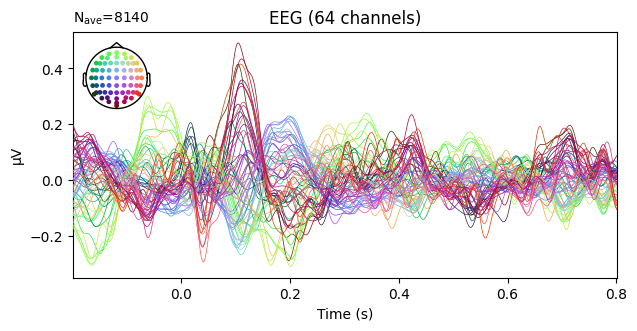

In [11]:
# beat epoching
trial_events = events
beat_events = generate_beat_events(raw, trial_events)
picks = mne.pick_types(raw.info, meg=False, eeg=True, eog=True, stim=True, exclude=[])
event_id = None # any
tmin = -0.2  # start of each epoch (200ms before the trigger)
tmax = 0.8  # end of each epoch (600ms after the trigger) - longest beat is 0.57s long
detrend = 0 # remove dc
beat_epochs = mne.Epochs(raw, beat_events, event_id,
                              tmin, tmax, preload=True,
                              proj=False, picks=picks, verbose=False)
print(beat_epochs)
a = beat_epochs.average().plot()

Using EOG channels: EXG1, EXG2, EXG3, EXG4
EOG channel index for this subject is: [64 65 66 67]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 sec)

Now detecting blinks and generating corresponding events
Found 1579 significant peaks
Number of EOG events detected: 1579


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


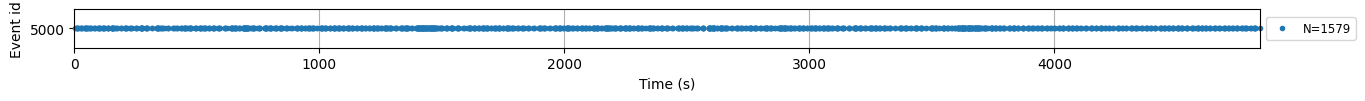

In [12]:
# EOG epoching

eog_event_id = 5000
eog_events = mne.preprocessing.find_eog_events(raw, eog_event_id)

plt.figure(figsize=(17,0.5))
axes = plt.gca()
mne.viz.plot_events(eog_events, raw.info['sfreq'], raw.first_samp, axes=axes)

# create epochs around EOG events
picks = mne.pick_types(raw.info, meg=False, eeg=True, eog=True, stim=True, exclude=[]) # FIXME
tmin = -.5
tmax = .5
eog_epochs = mne.Epochs(raw, events=eog_events, event_id=eog_event_id,
                    tmin=tmin, tmax=tmax, proj=False, picks=picks,
                    preload=True, verbose=False)

# Total 1579 eye blinksb

In [ ]:
# compute ica
ica = compute_ica(beat_epochs)
plot_ica_components(ica)

Fitting ICA to data using 64 channels (please be patient, this may take a while)


<ipython-input-5-256a14f5d92c>:4: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(beat_epochs)


In [ ]:
# find eog artifact
eog_inds, scores = find_eog_artifact_sources(ica, raw)

In [ ]:
# detect and merge artifact
# eog_exclude_indx = []
# suggested_artifact_components = auto_detect_artifact_components(ica, beat_epochs, eog_exclude_inds)

In [ ]:
# experiment
ecg_idx, ecg_score = ica.find_bads_ecg(beat_epochs)
eog_idx, eog_score = ica.find_bads_eog(beat_epochs)
mus_idx, mus_score = ica.find_badas_muscle(beat_epochs)

In [ ]:
# exclude ica components
ica.exclude = []



# Machine Learning
1. Perception vs. Imagination
2. Pop song vs. Instrument music (perception, without lyrics)
3. Lyrics vs. No Lyrics vs. Instrument
4. Cued vs. Not Cued
5. Stimulus classification

## Data Preparation

In [9]:
subjects = []
for root, dir, files in os.walk(dir_path):
  for f in files:
    if ".fif" in f:
      subjects.append(f)
subjects

['P14-raw.fif',
 'P13-raw.fif',
 'P09-raw.fif',
 'P07-raw.fif',
 'P06-raw.fif',
 'P05-raw.fif',
 'P04-raw.fif',
 'P12-raw.fif',
 'P11-raw.fif',
 'P01-raw.fif']

In [ ]:
data_list, labels, groups = [], [], []
for subject in subjects:
  raw, event = read_data(subject, filter=True)
  data, label, group = generate_data_and_label(raw, event, condition=1)
  data_list.append(data)
  labels.append(label)
  groups.append(group)

In [58]:
picks = mne.pick_types(raw.info, meg=False, eeg=True, eog=False, stim=False, exclude=[])
listen_with_cue_epochs = mne.Epochs(raw, trial_events, [id*10 + 1 for id in STIMULUS_IDS],
                      -1, 5, preload=True,
                      proj=False, picks=picks, verbose=False)

In [59]:
listen_with_cue_epochs.get_data().shape

(60, 64, 3073)

## Feature Generation

In [11]:
from scipy import stats
def mean(data):
    return np.mean(data,axis=-1)
    
def std(data):
    return np.std(data,axis=-1)

def ptp(data):
    return np.ptp(data,axis=-1)

def var(data):
        return np.var(data,axis=-1)

def minim(data):
      return np.min(data,axis=-1)


def maxim(data):
      return np.max(data,axis=-1)

def argminim(data):
      return np.argmin(data,axis=-1)


def argmaxim(data):
      return np.argmax(data,axis=-1)

def mean_square(data):
      return np.mean(data**2,axis=-1)

def rms(data): #root mean square
      return  np.sqrt(np.mean(data**2,axis=-1))  

def abs_diffs_signal(data):
    return np.sum(np.abs(np.diff(data,axis=-1)),axis=-1)


def skewness(data):
    return stats.skew(data,axis=-1)

def kurtosis(data):
    return stats.kurtosis(data,axis=-1)

def concatenate_features(data):
    return np.concatenate((mean(data),std(data),ptp(data),var(data),minim(data),maxim(data),argminim(data),argmaxim(data),
                          mean_square(data),rms(data),abs_diffs_signal(data), skewness(data), kurtosis(data)),axis=-1)


In [ ]:
raw, trial_events = read_data("P01-raw.fif", filter=True)
data_array, label_array, group_array = generate_data_and_label(raw, trial_events, condition=1)

In [12]:
data_array = np.vstack(data_list)
label_array = np.hstack(labels)
group_array = np.hstack(groups)
data_array.shape, label_array.shape, group_array.shape

((1200, 64, 3073), (1200,), (1200,))

In [13]:
from tqdm import tqdm_notebook
features=[]
for data in tqdm_notebook(data_array):
    features.append(concatenate_features(data))
features=np.array(features)
features.shape

<ipython-input-13-69f2cdc0fdb1>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for data in tqdm_notebook(data_array):


  0%|          | 0/1200 [00:00<?, ?it/s]

(1200, 832)

In [ ]:
# Check NaN
for i in range(features.shape[1]):
  if np.sum(np.isnan(features[:, i])) > 0:
    print(i)

## CNN

In [ ]:
from tensorflow.keras.layers import Conv1D,BatchNormalization,LeakyReLU,MaxPool1D,\
GlobalAveragePooling1D,Dense,Dropout,AveragePooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.backend import clear_session
def cnnmodel():
    clear_session()
    model=Sequential()
    model.add(Conv1D(filters=5,kernel_size=3,strides=1,input_shape=(3073,69)))#1
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(MaxPool1D(pool_size=2,strides=2))#2
    model.add(Conv1D(filters=5,kernel_size=3,strides=1))#3
    model.add(LeakyReLU())
    model.add(MaxPool1D(pool_size=2,strides=2))#4
    model.add(Dropout(0.5))
    model.add(Conv1D(filters=5,kernel_size=3,strides=1))#5
    model.add(LeakyReLU())
    model.add(AveragePooling1D(pool_size=2,strides=2))#6
    model.add(Dropout(0.5))
    model.add(Conv1D(filters=5,kernel_size=3,strides=1))#7
    model.add(LeakyReLU())
    model.add(AveragePooling1D(pool_size=2,strides=2))#8
    model.add(Conv1D(filters=5,kernel_size=3,strides=1))#9
    model.add(LeakyReLU())
    model.add(GlobalAveragePooling1D())#10
    model.add(Dense(1,activation='sigmoid'))#11
    
    model.compile('adam',loss='binary_crossentropy',metrics=['accuracy'])
    return model

model=cnnmodel()
model.summary()

## SVM

In [ ]:
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GroupKFold, GridSearchCV
from sklearn.metrics import accuracy_score

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, label_array, test_size=0.2, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


# Define the parameter grid for GridSearchCV
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
}

# Define the GroupKFold cross-validation
num_splits = 5
group_kfold = GroupKFold(num_splits)
group_array = np.arange(X_train.shape[0]) // (X_train.shape[0] / num_splits)

# Initialize the SVM classifier
svm = SVC()

# Perform GridSearchCV using GroupKFold cross-validation
grid_search = GridSearchCV(svm, param_grid, cv=group_kfold)

# Fit the model on the training data
grid_search.fit(X_train, y_train, groups=group_array)

# Get the best model based on validation score
best_model = grid_search.best_estimator_

# Predict on the test data using the best model
y_pred = best_model.predict(X_test)

# Evaluate the accuracy on the test data
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)

(960, 832) (960,)
(240, 832) (240,)


## Traning for Classification - Logistic Regression
1. Perception vs. Imagination
2. Pop song vs. Instrument music (perception, without lyrics)
3. Lyrics vs. No Lyrics vs. Instrument
4. Cued vs. Not Cued
5. Stimulus classification

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold,GridSearchCV,cross_val_score,cross_validate 

In [20]:
# 1. Perception vs. Imagination
clf=LogisticRegression()
gkf=GroupKFold(n_splits=5)
param_grid = {'classifier__C': [0.01,0.05,0.1,0.5, 1,2,3,4,5,8, 10,12,15]}
pipe=Pipeline([('scaler',StandardScaler()),('classifier',clf)])
# gscv=GridSearchCV(pipe,param_grid,cv=gkf,n_jobs=16)
# gscv.fit(features,label_array, groups=group_array)

GridSearchCV(cv=GroupKFold(n_splits=5),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier', LogisticRegression())]),
             n_jobs=16,
             param_grid={'classifier__C': [0.01, 0.05, 0.1, 0.5, 1, 2, 3, 4, 5,
                                           8, 10, 12, 15]})

In [ ]:
for train_index, val_index in gkf.split(data_array, label_array, groups=group_array):
    train_features,train_labels=data_array[train_index],label_array[train_index]
    val_features,val_labels=data_array[val_index],label_array[val_index]

In [24]:
gscv.cv_results_

{'mean_fit_time': array([0.79237289, 4.72167406, 4.4737565 , 3.00247736, 3.04480176,
        3.80093217, 3.74208646, 2.87673373, 2.95788527, 3.00950093,
        2.90199409, 2.47469854, 2.16478071]),
 'std_fit_time': array([0.23625093, 0.33329002, 0.19296286, 0.80748062, 0.39304932,
        0.39041622, 0.18129419, 0.27446186, 0.36978014, 0.11791295,
        0.07211849, 0.13414034, 0.08026651]),
 'mean_score_time': array([0.03856359, 0.06271281, 0.06484551, 0.04692073, 0.07817044,
        0.05209336, 0.03023295, 0.05461326, 0.04211364, 0.04113488,
        0.02472558, 0.01667352, 0.00730653]),
 'std_score_time': array([0.0159467 , 0.02429003, 0.02615275, 0.01758889, 0.05890481,
        0.0144934 , 0.00945738, 0.02285089, 0.01850616, 0.02736725,
        0.01177163, 0.01528221, 0.00781884]),
 'param_classifier__C': masked_array(data=[0.01, 0.05, 0.1, 0.5, 1, 2, 3, 4, 5, 8, 10, 12, 15],
              mask=[False, False, False, False, False, False, False, False,
                    False, Fal

In [25]:
gscv.best_params_

{'classifier__C': 0.01}

In [21]:
gscv.best_score_

0.633

In [52]:
gscv.best_score_

0.5233333333333332

In [17]:
# filtered, P01
gscv.best_score_

0.6633333333333333

In [105]:
# not filtered, P01
gscv.best_score_

0.7233333333333334

In [106]:
popsong_ids = [11, 12, 13, 14] # without lyrics
instrument_ids = [21, 22, 23, 24]
popsong_epochs = mne.Epochs(raw, trial_events, [i*10 + 1 for i in popsong_ids],
                      tmin, tmax, preload=True,
                      proj=False, picks=picks, verbose=False).get_data()
instrument_epochs = mne.Epochs(raw, trial_events, [i*10 + 1 for i in instrument_ids],
                      tmin, tmax, preload=True,
                      proj=False, picks=picks, verbose=False).get_data()
print(popsong_epochs.shape, instrument_epochs.shape)

(20, 69, 513) (20, 69, 513)


In [107]:
popsong_epochs_labels = [0] * popsong_epochs.shape[0]
instrument_epochs_labels = [1] * instrument_epochs.shape[0]

# concat data and label
data_list = np.concatenate((popsong_epochs, instrument_epochs), axis=0)
label_list = popsong_epochs_labels + instrument_epochs_labels

group_list = [[i] * 5 for i in range(4)]
group_list = group_list + group_list
group_array = np.hstack(group_list)

data_array = data_list
label_array = np.array(label_list)
data_array.shape, label_array.shape, group_array.shape

((40, 69, 513), (40,), (40,))

In [110]:
features=[]
for data in tqdm_notebook(data_array):
    features.append(concatenate_features(data))
features=np.array(features)
features.shape

<ipython-input-110-aceb17c2c812>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for data in tqdm_notebook(data_array):


  0%|          | 0/40 [00:00<?, ?it/s]

(40, 897)

In [113]:
# 1. Perception vs. Imagination
clf=LogisticRegression()
gkf=GroupKFold(n_splits=3)
param_grid = {'classifier__C': [0.01,0.05,0.1,0.5, 1,2,3,4,5,8, 10,12,15]}
pipe=Pipeline([('scaler',StandardScaler()),('classifier',clf)])
gscv=GridSearchCV(pipe,param_grid,cv=gkf,n_jobs=16)
gscv.fit(features,label_array, groups=group_array)

GridSearchCV(cv=GroupKFold(n_splits=3),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier', LogisticRegression())]),
             n_jobs=16,
             param_grid={'classifier__C': [0.01, 0.05, 0.1, 0.5, 1, 2, 3, 4, 5,
                                           8, 10, 12, 15]})

In [114]:
gscv.best_score_

0.75